In [1]:
###Calculate APOGEE field mass with PARSEC isochrones
import astropy
from astropy.io import fits, ascii
from astropy.table import Table
import numpy as np
from scipy.interpolate import interp1d

def apogee_field_mass(age,metallicity,maxabsH,minabsH,selectfunc,number,parsec_path):
    
    """
    This is used to calculate the mass of stars in a field
    - age: age of stars to use to pick out isochrone
    - metallicity: metallicity of stars to use to pick out isochrone
    - maxabsH: max value of H for the field 
    - minabsH: min vale of H for the field
    - selectfunc: selection function for the field
    - number: number of stars observed
    - parsec_path: dat file of PARSEC isochrones
    """
    
    ###Load in isochrones from parsec
    parsecall = ascii.read(parsec_path, format='basic', delimiter='\s')
    rgb = np.where(parsecall['label']==3)
    parsec = parsecall[rgb]
    
    #find closest parsec isochrone z fraction
    age = np.log10(age*(10**9))
    parsec_mets = np.unique(np.asarray((np.log10(parsec['Zini']/0.02))))
    met_index = np.absolute(parsec_mets-metallicity*np.ones(len(parsec_mets))).argmin()
    z_iso = 0.02*(10**parsec_mets[met_index])
    
    #find closest parsec isochrone age
    parsec_ages = np.unique(np.asarray(parsec['logAge']))
    age_index = np.absolute(parsec_ages-age*np.ones(len(parsec_ages))).argmin()
    age_iso = parsec_ages[age_index]
    
    #pick out isochrone, interpolate, and find difference
    single_iso = np.where((parsec['Zini']==z_iso)&(parsec['logAge']==age_iso)&(parsec['Hmag']<=maxabsH))

    upto = np.where(parsec[single_iso]['Hmag']==min(parsec[single_iso]['Hmag']))
    new_parsec = parsec[single_iso][0:int(np.squeeze(upto))]
    
    inter_iso = interp1d(new_parsec['Hmag'][::-1],new_parsec['int_IMF'][::-1],kind='cubic',bounds_error=False,
                         fill_value='extrapolate',assume_sorted=False) #fill_value=(np.nan,np.nan)
    
    diff_IMF = np.absolute(inter_iso(maxabsH)-inter_iso(minabsH))
    
    return (selectfunc*number)/diff_IMF
    

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat',format='basic', delimiter='\s')
# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

In [9]:
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Structure/lmc_rgbmembers_r13-l33-58672.fits.gz',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Structure/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

In [4]:
def dist2LMC(ra, dec, alph0, delt0, pa, io):
    '''
    - ra: right ascension of stars
    - dec: declination of stars
    - alph0: right ascension of center of LMC
    - delt0: declination of center of LMC
    - pa: position angle of line of nodes
    - io: inclination of LMC disk
    Calculate distance to stars in LMC assuming an inclined disk in the sky
    '''
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis

def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

stardist = dist2LMC(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsH = absmag(clndr16['H'],stardist)-clndr16['AK_TARG']
corabsK = absmag(clndr16['K'],stardist)-clndr16['AK_TARG']

In [5]:
#Field LMC9

lmc9 = np.where(clndr16['FIELD']=='LMC9')

apogee_field_mass(8.7,-0.6,max(corabsH[lmc9]),min(corabsH[lmc9]),
                  clndr16[lmc9]['SELECTFUNC'][0],len(np.squeeze(lmc9)),
                  '/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat')




325779784.3898541

In [10]:
plt.figure(figsize=[10,10])
plt.scatter(range(len(parsec[single_iso]['Hmag'])),parsec[single_iso]['Hmag'])
for j in range(len(parsec[single_iso])):
    plt.text(range(len(parsec[single_iso]['Hmag']))[j]*(1.0-0.001),
             parsec[single_iso]['Hmag'][j]*(1.0-0.001),range(len(parsec[single_iso]))[j],
             fontsize=14)
plt.axhline(-6.027)
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(range(len(parsec[single_iso]['int_IMF'])),parsec[single_iso]['int_IMF'])
for j in range(len(parsec[single_iso])):
    plt.text(range(len(parsec[single_iso]['int_IMF']))[j]*(1.0-0.001),
             parsec[single_iso]['int_IMF'][j]*(1.0-0.001),range(len(parsec[single_iso]))[j],
             fontsize=14)
# plt.axhline(-6.027)
plt.show()

plt.figure(figsize=[10,10])
plt.scatter(parsec[single_iso]['Hmag'],parsec[single_iso]['int_IMF'])
for j in range(len(parsec[single_iso])):
    plt.text(parsec[single_iso]['Hmag'][j]*(1.0-0.001),parsec[single_iso]['int_IMF'][j]*(1.0-0.001),
             range(len(parsec[single_iso]))[j],fontsize=14)
plt.show()

# print(min(parsec[single_iso]['Hmag']))
# print(parsec[single_iso]['Hmag'][5])

NameError: name 'single_iso' is not defined

<Figure size 720x720 with 0 Axes>

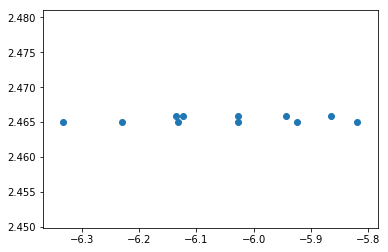

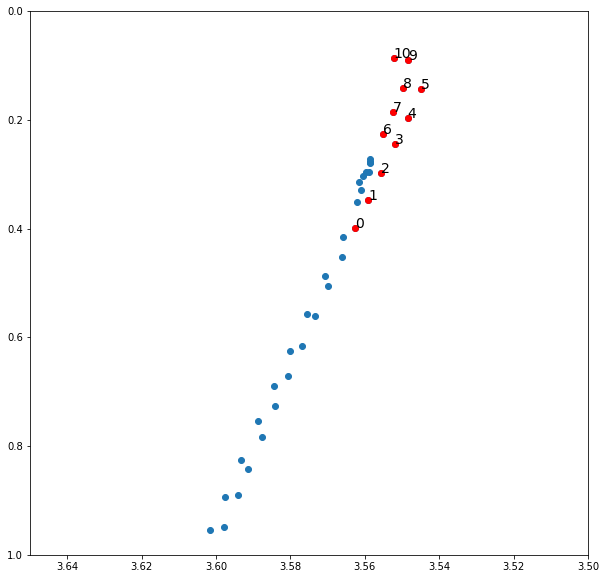

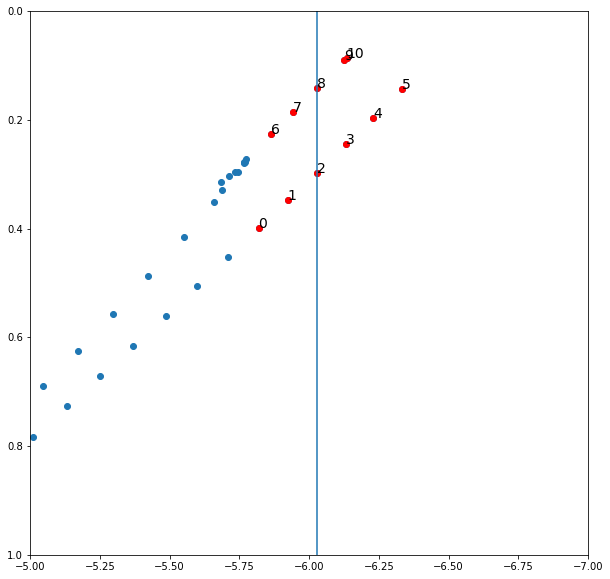

In [169]:
plt.scatter(x1,y1)
plt.show()

whole = np.where((parsecall['logAge'] == age_iso)&(parsecall['Zini'] == z_iso))

plt.figure(figsize=[10,10])
plt.scatter(parsecall[whole]['logTe'],parsecall[whole]['logg'])
plt.scatter(parsec[single_iso]['logTe'],parsec[single_iso]['logg'],c='r')
for j in range(len(parsec[single_iso])):
    plt.text(parsec[single_iso]['logTe'][j]*(1.0),
             parsec[single_iso]['logg'][j]*(1.0),range(len(parsec[single_iso]))[j],
             fontsize=14)
plt.xlim(3.5,3.65)
plt.ylim(0,1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

# plt.scatter(parsecall[whole]['logTe'],parsecall[whole]['logg'])
plt.figure(figsize=[10,10])
plt.scatter(parsecall[whole]['Hmag'],parsecall[whole]['logg'])
plt.scatter(parsec[single_iso]['Hmag'],parsec[single_iso]['logg'],c='r')
for j in range(len(parsec[single_iso])):
    plt.text(parsec[single_iso]['Hmag'][j]*(1.0),
             parsec[single_iso]['logg'][j]*(1.0),range(len(parsec[single_iso]))[j],
             fontsize=14)
plt.xlim(-7,-5)
plt.ylim(0,1)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.axvline(-6.027)
plt.show()

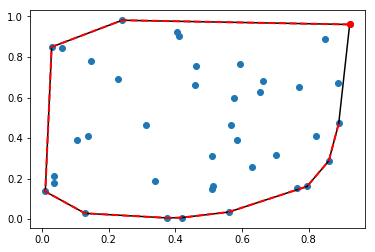

In [26]:
import numpy as np
from scipy.spatial import ConvexHull
points = np.random.rand(40, 2)   # 30 random points in 2-D
hull = ConvexHull(points)
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.savefig('convexhullexample.pdf',bbox_inches='tight')
plt.show()


In [11]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

In [32]:
set(parsec['logAge'])

{8.0,
 8.15,
 8.3,
 8.45,
 8.6,
 8.75,
 8.9,
 9.05,
 9.2,
 9.35,
 9.5,
 9.65,
 9.8,
 9.95,
 10.1}

0.006324555320336759

Text(0.5, 1.0, 'Color as Age')

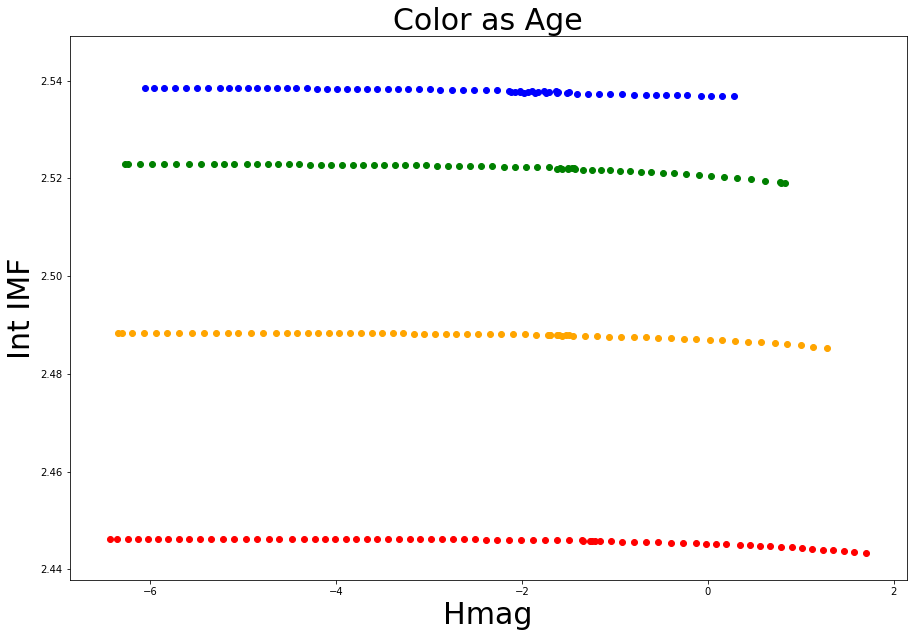

In [33]:
y = np.where((parsec['logAge']==9.35)&(parsec['Zini']==0.0057617))
x = np.where((parsec['logAge']==9.5)&(parsec['Zini']==0.0057617)) 
z = np.where((parsec['logAge']==9.8)&(parsec['Zini']==0.0057617)) 
o = np.where((parsec['logAge']==10.1)&(parsec['Zini']==0.0057617))
plt.figure(figsize=[15,10])
plt.scatter(parsec['Hmag'][y],parsec['int_IMF'][y],c='b')
plt.scatter(parsec['Hmag'][x],parsec['int_IMF'][x],c='g')
plt.scatter(parsec['Hmag'][z],parsec['int_IMF'][z],c='orange')
plt.scatter(parsec['Hmag'][o],parsec['int_IMF'][o],c='r')
plt.ylabel('Int IMF',fontsize=30)
plt.xlabel('Hmag',fontsize=30)
plt.title('Color as Age',fontsize=30)
# plt.colorbar()